## 0a

In [1]:
from pathlib import Path
import os
import fuzzywuzzy
import random
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import cv2
import shutil
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [2]:
# Inställning av sökvägar
tiny_data_path = Path().absolute().parent
tiny_train_path = tiny_data_path / "Lab2"/ "experiment_tiny_data" / "train"
tiny_val_path = tiny_data_path / "Lab2"/ "experiment_tiny_data" / "val"
tiny_test_path = tiny_data_path / "Lab2"/ "experiment_tiny_data" / "test"
print(f"Data path1: {tiny_data_path}")
print(f"Train path1: {tiny_train_path}")
print(f"Validation path1: {tiny_val_path}")
print(f"Test path1: {tiny_test_path}")

# Anpassar sökvägarna för körning i Kaggle
if "KAGGLE_KERNEL_RUN_TYPE" in os.environ:
    tiny_data_path = Path().absolute().parent /"input"
    tiny_train_path = tiny_data_path / "train-data"
    tiny_val_path = tiny_data_path / "val-data"
    tiny_test_path = tiny_data_path / "test-data"

# Skriver ut sökvägarna för att bekräfta att de är rätt
print(f"Data path: {tiny_data_path}")
print(f"Train path: {tiny_train_path}")
print(f"Validation path: {tiny_val_path}")
print(f"Test path: {tiny_test_path}")

Data path1: c:\Users\Sandra\Documents\Github\AI-Sandra-Andersson-OPA23\labs
Train path1: c:\Users\Sandra\Documents\Github\AI-Sandra-Andersson-OPA23\labs\Lab2\experiment_tiny_data\train
Validation path1: c:\Users\Sandra\Documents\Github\AI-Sandra-Andersson-OPA23\labs\Lab2\experiment_tiny_data\val
Test path1: c:\Users\Sandra\Documents\Github\AI-Sandra-Andersson-OPA23\labs\Lab2\experiment_tiny_data\test
Data path: c:\Users\Sandra\Documents\Github\AI-Sandra-Andersson-OPA23\labs
Train path: c:\Users\Sandra\Documents\Github\AI-Sandra-Andersson-OPA23\labs\Lab2\experiment_tiny_data\train
Validation path: c:\Users\Sandra\Documents\Github\AI-Sandra-Andersson-OPA23\labs\Lab2\experiment_tiny_data\val
Test path: c:\Users\Sandra\Documents\Github\AI-Sandra-Andersson-OPA23\labs\Lab2\experiment_tiny_data\test


## 0b

In [3]:

# Listar alla filer i mappen
tiny_train_files = list(tiny_train_path.glob('*'))
print(f"Number of files found: {len(tiny_train_files)}")

# Väljer slumpmässigt 10 filer från listan
tiny_random_img = random.sample(tiny_train_files, 10)

# Loopar genom de slumpmässigt utvalda bilderna
for image_file in tiny_random_img:
    # skriver ut bilderna 
    image = plt.imread(image_file)
    
    # Tar fram filnamnet (label)
    label = image_file.stem
    
    plt.imshow(image)
    plt.title(label)
    plt.axis('off')
    plt.show()


Number of files found: 0


ValueError: Sample larger than population or is negative

## 0c

In [6]:
# Skapar mappar för uppdelning om de inte redan finns
folders = [
    ('experiment_tiny_data', ['test', 'train', 'val']),
           ('experiment_tiny_data', ['test', 'train', 'val']),
           ('original_data', ['test', 'train'])]

for folder, subfolders in folders:
    for subfolder in subfolders:
        Path(folder, subfolder).mkdir(parents=True, exist_ok=True)

## 0d

In [7]:

# Skapar train, val och test mappar om de inte redan finns
tiny_test = tiny_test_path
tiny_train = tiny_train_path
tiny_val = tiny_val_path
original_data = tiny_data_path / "Lab2"/ "original_data" / "train"

print(original_data)
print(tiny_test_path)

# Antal exempel för varje delmängd
train_size = 160
val_size = 40
test_size = 50

# Antal exempel för varje klass
dogs_train_size = 80
cats_train_size = 80
dogs_val_size = 20
cats_val_size = 20
dogs_test_size = 25
cats_test_size = 25

# Listar alla bilder för hundar och katter i originaldatasetet
cat_images = list(original_data.glob('cat*.jpg'))
dog_images = list(original_data.glob('dog*.jpg'))

print(len(dog_images))
print(len(cat_images))

# Kontrollfunktion för att se om mapparna redan är fyllda
def check_files(folder, size):
    return len(list(folder.glob('*.jpg'))) >= size

# Funktion för att dela upp och kopiera filer
def distribute_files(source, train_num, val_num, test_num, train_folder, val_folder, test_folder):
    if not (check_files(train_folder, train_num) and check_files(val_folder, val_num) and check_files(test_folder, test_num)):
        images = list(source.glob('*.jpg'))
        random.shuffle(images)
        train = images[:train_num]
        val = images[train_num:train_num + val_num]
        test = images[train_num + val_num:train_num + val_num + test_num]

        for img in train:
            shutil.copy(img, train_folder)
        for img in val:
            shutil.copy(img, val_folder)
        for img in test:
            shutil.copy(img, test_folder)
        print("Files have been allocated and copied.")
    else:
        print("Files are already distributed.")

# Distribuera hund- och kattbilder
distribute_files(original_data / 'dog', dogs_train_size, dogs_val_size, dogs_test_size, tiny_train, tiny_val, tiny_test)
distribute_files(original_data / 'cat', cats_train_size, cats_val_size, cats_test_size, tiny_train, tiny_val, tiny_test)

print("Train|val|test-split har genomförts och datan har sparats i sina respektive mappar.")


c:\Users\Sandra\Documents\Github\AI-Sandra-Andersson-OPA23\labs\Lab2\original_data\train
c:\Users\Sandra\Documents\Github\AI-Sandra-Andersson-OPA23\labs\Lab2\experiment_tiny_data\test
12500
12500
Files have been allocated and copied.
Files have been allocated and copied.
Train|val|test-split har genomförts och datan har sparats i sina respektive mappar.


In [8]:
#Använder denna som check men låter den vara utkommenterad då den ger så mycket information.

# Loopar igenom alla filer i mappen och skriver ut deras attribut
for file in tiny_train_path.iterdir():
    #print(f"File Name: {file.name}")
    #print(f"File Type: {'File' if file.is_file() else 'Directory'}")
    #print(f"File Size: {file.stat().st_size} bytes")
    #print(f"File Creation Time: {file.stat().st_ctime}")
    #print(f"File Modification Time: {file.stat().st_mtime}")
    # Extraherar labelsvektorn från filnamnet (om den finns)
    labels_vector = file.name.split('_')[-1].split('.')[0]
    #print(f"File Label Vector: {labels_vector}")

## 0e

                                          image_path
0  c:\Users\Sandra\Documents\Github\AI-Sandra-And...
1  c:\Users\Sandra\Documents\Github\AI-Sandra-And...
2  c:\Users\Sandra\Documents\Github\AI-Sandra-And...
3  c:\Users\Sandra\Documents\Github\AI-Sandra-And...
4  c:\Users\Sandra\Documents\Github\AI-Sandra-And...


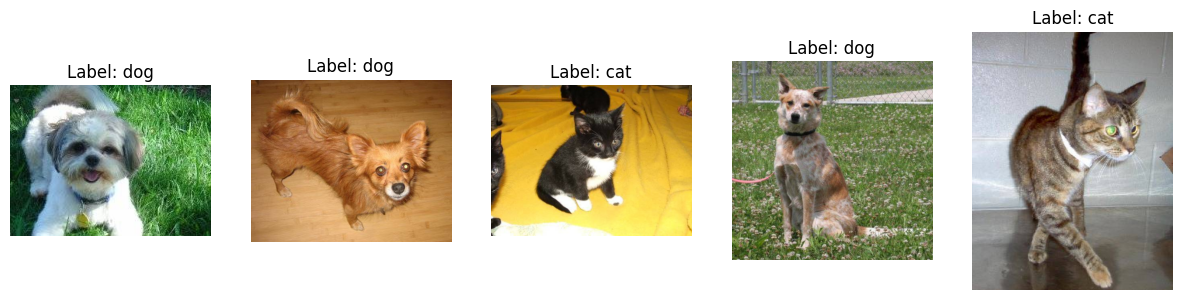

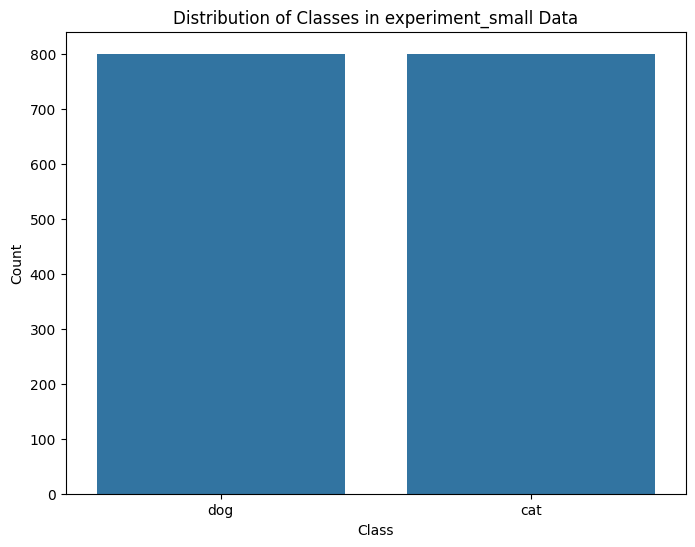

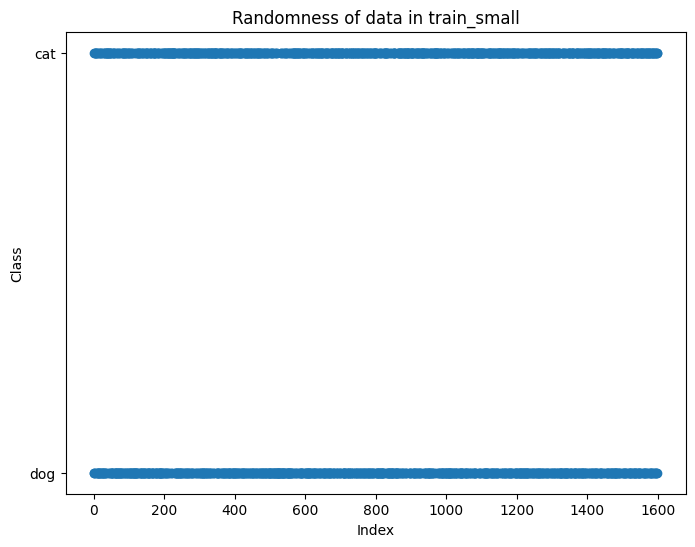

In [9]:
# Listar filer i mappen med filtillägget .jpg
image_files = list(tiny_train_path.glob('*.jpg'))

# Skapar en DataFrame med filvägarna
small_train_data = pd.DataFrame({'image_path': [str(file) for file in image_files]})

# Visar de första raderna i datasetet för att kontrollera att det har lästs in korrekt
print(small_train_data.head())

# Plockar ut labelsvektorerna
# Lägger till en kolumn 'label' för att simulera datasetets struktur
small_train_data['label'] = ['cat' if 'cat' in file else 'dog' for file in small_train_data['image_path']]
one_hot_encoded_labels = pd.get_dummies(small_train_data['label'])

# Lägger till labelsvektorerna till DataFramen
small_train_data = pd.concat([small_train_data, one_hot_encoded_labels], axis=1)

# Samplar slumpmässigt rader från DataFramen för att få en mer slumpad ordning
small_train_data = small_train_data.sample(frac=1).reset_index(drop=True)

# Plottar några bilder med deras respektive labels för att kontrollera att det är rätt
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, (index, row) in enumerate(small_train_data.head().iterrows()):
    img = plt.imread(row['image_path'])
    axes[i].imshow(img)
    axes[i].set_title(f"Label: {row['label']}")
    axes[i].axis('off')
plt.show()

# Skapar diagram för att kontrollera att datasetet är balanserat
# Plottar antalet förekomster av varje klass i datasetet
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=small_train_data)
plt.title('Distribution of Classes in experiment_small Data')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Skapar diagram för att kontrollera att datasetet är slumpat
# Kontrollerar fördelningen av klasser över index för att se så det inte finns något mönster
plt.figure(figsize=(8, 6))
plt.plot(small_train_data.index, small_train_data['label'], marker='o', linestyle='')
plt.title('Randomness of data in train_small')
plt.xlabel('Index')
plt.ylabel('Class')
plt.show()


# 1a

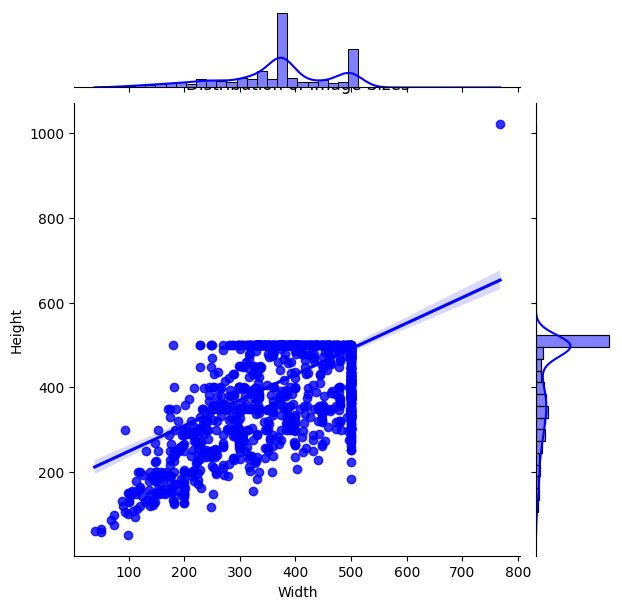

In [10]:
# Skapar en lista med bildbredd och bildhöjd
image_sizes = [(plt.imread(file).shape[0], plt.imread(file).shape[1]) for file in small_train_data['image_path']]

# Tar ut bildbredd och bildhöjd till separata listor
widths = [size[0] for size in image_sizes]
heights = [size[1] for size in image_sizes]

# Skapar en jointplot för att visualisera bildstorlekarna
sns.jointplot(x=widths, y=heights, kind='reg', color='blue')
plt.xlabel('Width')
plt.ylabel('Height')
plt.title('Distribution of Image Sizes', pad=10)
plt.show()

# 1b och 1c

Här har jag sett att vi har några väldigt stora och några väldigt små bilder som troligtvis inte kommer att sscalas så bra, så jag väljer att ta bort dessa redan nu.

In [11]:
def prepare_images(data_path, min_size=(70, 30), max_size=(650, 600)):
    image_files = list(data_path.glob('*.jpg'))
    print(f"Found {len(image_files)} images in {data_path}")
    images = []
    labels = []

    for file in image_files:
        img = cv2.imread(str(file))
        if img is None:
            print(f"Failed to load image {file}")
            continue
        
        # Kontrollera bildstorleken
        if img.shape[0] < min_size[0] or img.shape[1] < min_size[1] or img.shape[0] > max_size[0] or img.shape[1] > max_size[1]:
            print(f"Skipping image {file} due to inappropriate size: {img.shape}")
            continue

        # Ändrar storleken på bilden till önskat format
        img = cv2.resize(img, (250, 200))  
        # Konverterar färgerna i bilderna från BGR till RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
        images.append(img)
        label = 1 if 'dog' in file.stem else 0
        labels.append(label)
    
    images = np.array(images, dtype=np.float32) / 255.0
    labels = np.array(labels)
    return images, labels

X_train, y_train = prepare_images(tiny_train)
X_val, y_val = prepare_images(tiny_val)
X_test, y_test = prepare_images(tiny_test)

print(X_train)
print(y_train)
print(X_val)
print(y_val)
print(X_test)
print(y_test)

Found 1600 images in c:\Users\Sandra\Documents\Github\AI-Sandra-Andersson-OPA23\labs\Lab2\experiment_small_data\train
Skipping image c:\Users\Sandra\Documents\Github\AI-Sandra-Andersson-OPA23\labs\Lab2\experiment_small_data\train\cat.4821.jpg due to inappropriate size: (39, 60, 3)
Skipping image c:\Users\Sandra\Documents\Github\AI-Sandra-Andersson-OPA23\labs\Lab2\experiment_small_data\train\cat.835.jpg due to inappropriate size: (768, 1023, 3)
Skipping image c:\Users\Sandra\Documents\Github\AI-Sandra-Andersson-OPA23\labs\Lab2\experiment_small_data\train\cat.8504.jpg due to inappropriate size: (50, 66, 3)
Skipping image c:\Users\Sandra\Documents\Github\AI-Sandra-Andersson-OPA23\labs\Lab2\experiment_small_data\train\dog.8450.jpg due to inappropriate size: (68, 86, 3)
Skipping image c:\Users\Sandra\Documents\Github\AI-Sandra-Andersson-OPA23\labs\Lab2\experiment_small_data\train\dog.8570.jpg due to inappropriate size: (50, 59, 3)
Found 400 images in c:\Users\Sandra\Documents\Github\AI-Sand

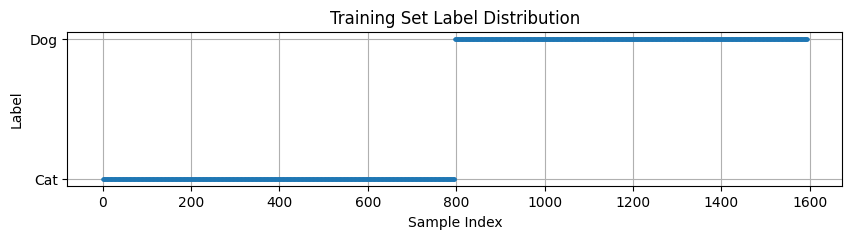

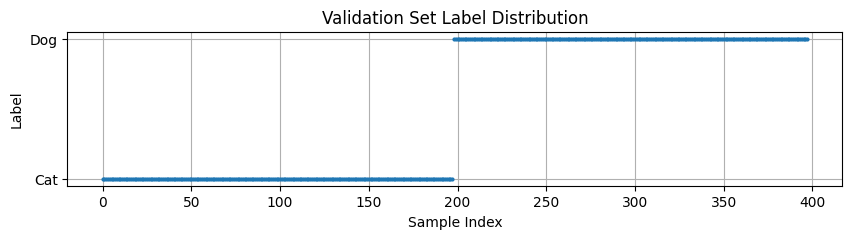

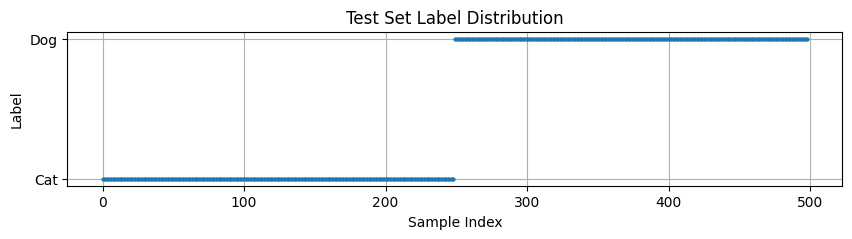

In [12]:
def plot_label_distribution(labels, title="Label Distribution"):
    plt.figure(figsize=(10, 2))
    plt.plot(labels, marker='o', linestyle='', markersize=2)
    plt.title(title)
    plt.xlabel('Sample Index')
    plt.ylabel('Label')
    plt.yticks([0, 1], ['Cat', 'Dog'])
    plt.grid(True)
    plt.show()

# Anropar funktionen för att visa label-distribution för varje dataset
plot_label_distribution(y_train, title="Training Set Label Distribution")
plot_label_distribution(y_val, title="Validation Set Label Distribution")
plot_label_distribution(y_test, title="Test Set Label Distribution")


In [13]:
def shuffle_data(X, y):
    # Skapar en array med index från 0 till antalet exempel
    indices = np.arange(X.shape[0])
    # Här blandas indexen
    np.random.shuffle(indices)
    # Applicerar den blandade ordningen på både bilder och etiketter
    X_shuffled = X[indices]
    y_shuffled = y[indices]
    return X_shuffled, y_shuffled

# Blandar träningsingsdatan
X_train, y_train = shuffle_data(X_train, y_train)

# Blandar valideringsdatan
X_val, y_val = shuffle_data(X_val, y_val)

# Blandar testdatan
X_test, y_test = shuffle_data(X_test, y_test)



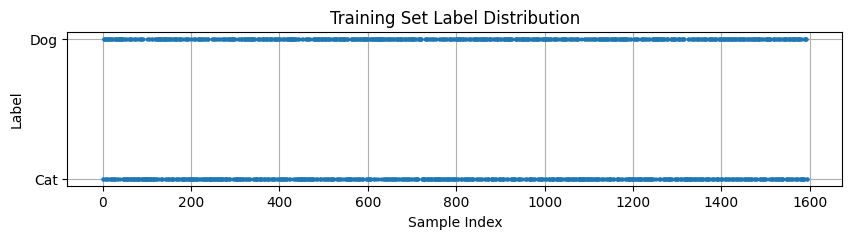

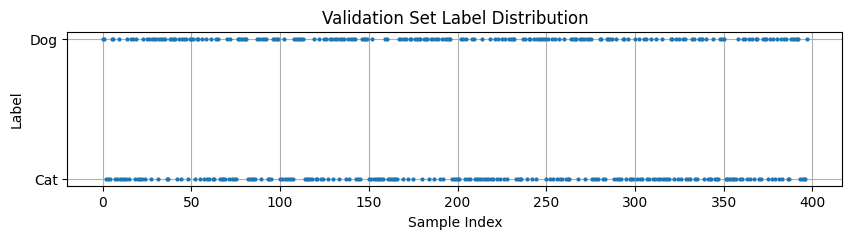

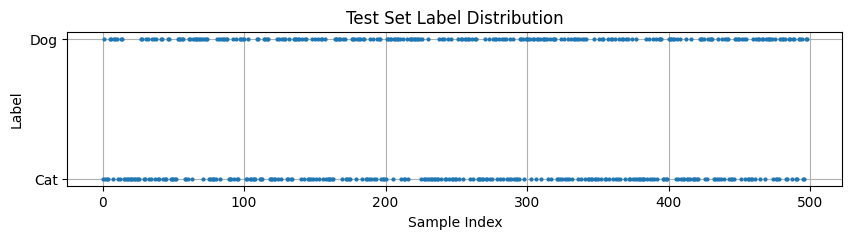

In [14]:
def plot_label_distribution(labels, title="Label Distribution"):
    plt.figure(figsize=(10, 2))
    plt.plot(labels, marker='o', linestyle='', markersize=2)
    plt.title(title)
    plt.xlabel('Sample Index')
    plt.ylabel('Label')
    plt.yticks([0, 1], ['Cat', 'Dog'])
    plt.grid(True)
    plt.show()

# Anropar funktionen för att visa label-distribution
plot_label_distribution(y_train, title="Training Set Label Distribution")
plot_label_distribution(y_val, title="Validation Set Label Distribution")
plot_label_distribution(y_test, title="Test Set Label Distribution")


In [15]:
X_train.shape

(1595, 200, 250, 3)

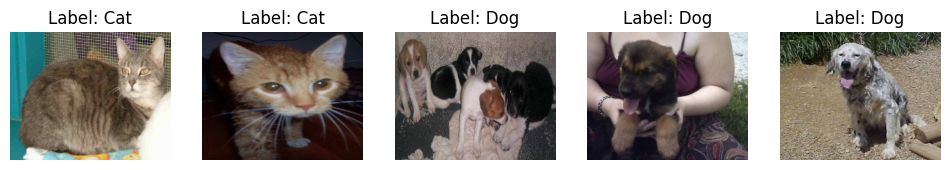

In [16]:
def plot_sample_images(images, labels, num_samples=5):
    plt.figure(figsize=(12, 2.4))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i])
        plt.title('Label: Dog' if labels[i] == 1 else 'Label: Cat')
        plt.axis('off')
    plt.show()

# Använder funktionen för att visa exempel från träningsdata
plot_sample_images(X_train, y_train)


In [17]:
y_train_onehot = to_categorical(y_train, num_classes=2)


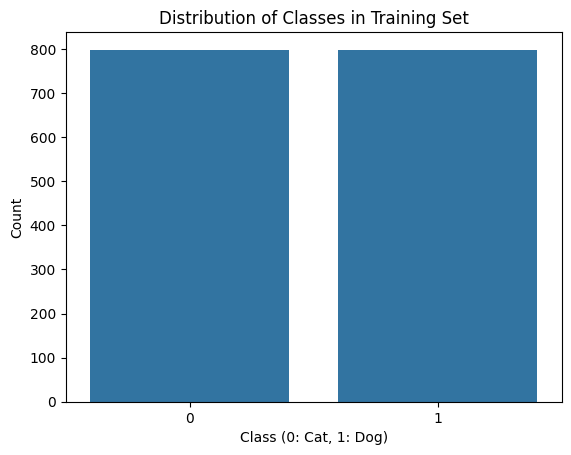

In [18]:
sns.countplot(x=np.argmax(y_train_onehot, axis=1))
plt.title('Distribution of Classes in Training Set')
plt.xlabel('Class (0: Cat, 1: Dog)')
plt.ylabel('Count')
plt.show()


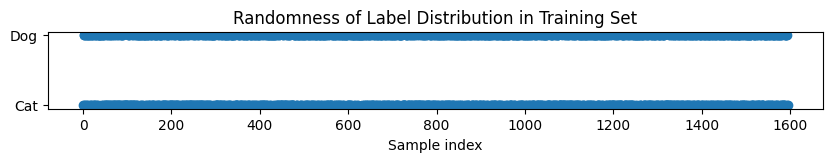

In [19]:
plt.figure(figsize=(10, 1))
plt.plot(np.argmax(y_train_onehot, axis=1), marker='o', linestyle='')
plt.title('Randomness of Label Distribution in Training Set')
plt.xlabel('Sample index')
plt.yticks([0, 1], ['Cat', 'Dog'])
plt.show()


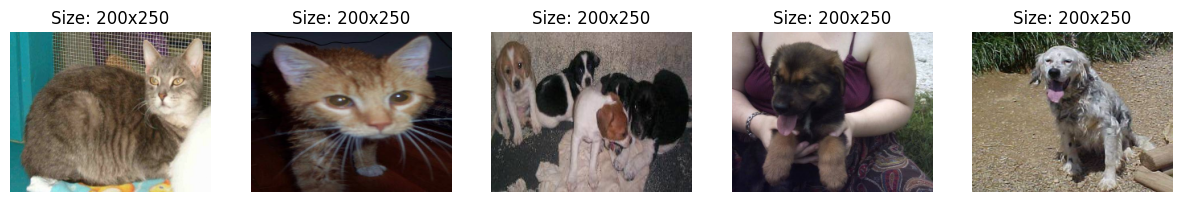

In [20]:
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, img in enumerate(X_train[:5]):
    axes[i].imshow(img)
    axes[i].set_title(f"Size: {img.shape[0]}x{img.shape[1]}")
    axes[i].axis('off')
plt.show()


## 1d

Augmentering används för att öka den mängd träningsdata man har att arbeta med genom att introducera variationer av befintlig data, vilket hjälper till att förbättra modellens generaliserbarhet och minskar även risken för överanpassning.

Jag har testat mig fram med olika parametrar men kom fram till att dessa fungerade bäst. Använde allt för hög rotation från början och fick inget bra resultat sen pratade jag men Björn som föreslog att jag skulle sänka den och då började resultaten förbättras. Använder ganska små skiftningar för att det det inte ska vara så kostsamt bland annat.

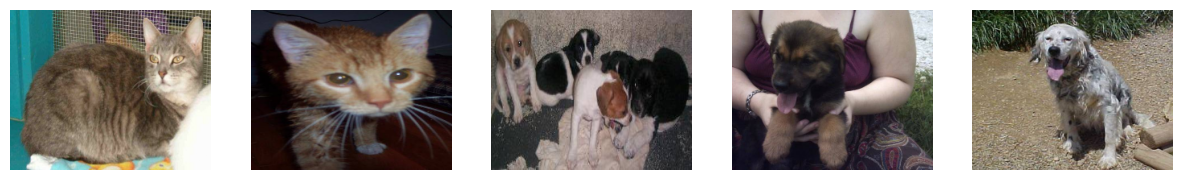

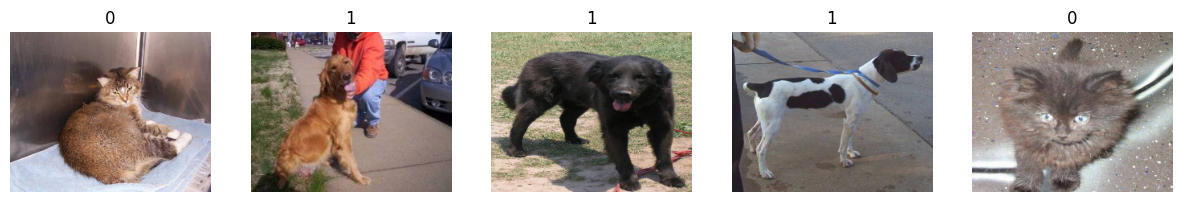

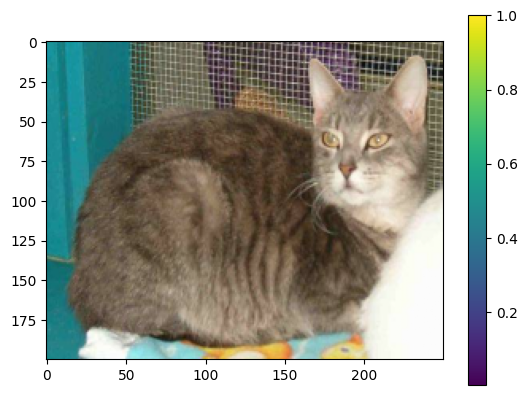

In [21]:
# Skapar en instans av ImageDataGenerator för data-augmentation
train_datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.25,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Skapar en generator från de skaldade bilderna
image_data_generator = train_datagen.flow(
    X_train,
    y_train,
    batch_size=5
)

# Visar några av de normaliserade bilderna innan augmentering
fig, ax = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    ax[i].imshow(X_train[i])
    ax[i].axis('off')
plt.show()

def display_augmented_images(images, labels, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i, ax in zip(range(num_images), axes):
        idx = np.random.randint(0, len(images))
        ax.imshow(images[idx])
        ax.set_title(f'{labels[idx]}')
        ax.axis('off')
    plt.show()
display_augmented_images(X_train, y_train)


plt.imshow(X_train[0])
plt.colorbar()
plt.show()


## 2a

# Första test utan augmentering

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 45s 866ms/step - accuracy: 0.4684 - loss: 1.2104 - val_accuracy: 0.5025 - val_loss: 0.6930
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 43s 866ms/step - accuracy: 0.5202 - loss: 0.6945 - val_accuracy: 0.5754 - val_loss: 0.6895
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 46s 915ms/step - accuracy: 0.5552 - loss: 0.6872 - val_accuracy: 0.6005 - val_loss: 0.6638
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 44s 881ms/step - accuracy: 0.6348 - loss: 0.6400 - val_accuracy: 0.6055 - val_loss: 0.6519
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 45s 903ms/step - accuracy: 0.6933 - loss: 0.6010 - val_accuracy: 0.6156 - val_loss: 0.6493
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 42s 848ms/step - accuracy: 0.7312 - loss: 0.5320 - val_accuracy: 0.6407 - val_loss: 0.6380
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 42s 848ms/step - accuracy: 0.7719 - loss: 0.4642 - val_accuracy: 0.6683 - val_loss: 0.7013
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 45s 906ms/step - accuracy: 0.8218 - loss: 0.3648 - val_accu

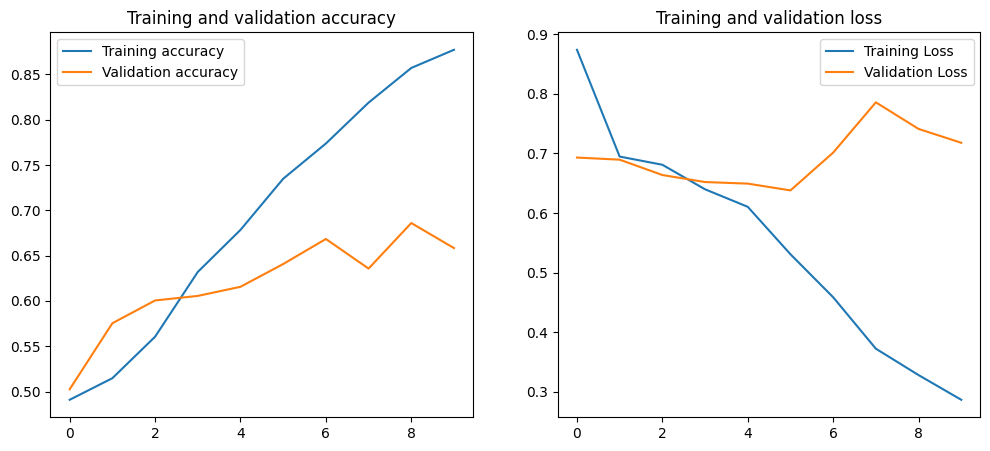

In [22]:
# Bygger en sequential model
def build_model():
    model = Sequential([
        Input(shape=(250, 200, 3)),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dropout(0.5),
        Dense(512, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = build_model()
model_plot = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

# Jämför modellen mot testdata
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")

def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

plot_training_history(model_plot)


Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 42s 845ms/step - accuracy: 0.8948 - loss: 0.2292 - val_accuracy: 0.6508 - val_loss: 1.0224
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 42s 847ms/step - accuracy: 0.9426 - loss: 0.1399 - val_accuracy: 0.6206 - val_loss: 1.1972
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 42s 845ms/step - accuracy: 0.9484 - loss: 0.1436 - val_accuracy: 0.6734 - val_loss: 1.1400
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 42s 847ms/step - accuracy: 0.9644 - loss: 0.1121 - val_accuracy: 0.6633 - val_loss: 1.4263
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 43s 858ms/step - accuracy: 0.9679 - loss: 0.0860 - val_accuracy: 0.6332 - val_loss: 1.3232
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 43s 859ms/step - accuracy: 0.9846 - loss: 0.0559 - val_accuracy: 0.6332 - val_loss: 1.6922
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.


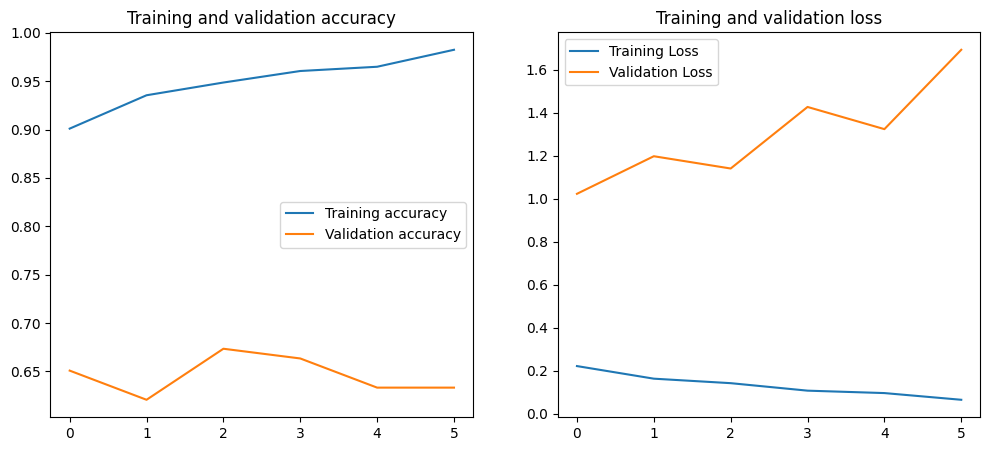

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 0.6944 - loss: 0.8709
Test Accuracy: 0.6853707432746887


In [23]:

# Definierar EarlyStopping callback
early_stopper = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

# Tränar modellen med EarlyStopping
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopper]
)

# Plottar träningshistoriken
plot_training_history(history)

# Jämför modellen mot testdatan efter träningen har stoppats tidigt
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")


In [24]:
X_train

array([[[[0.11372549, 0.5647059 , 0.5764706 ],
         [0.10980392, 0.57254905, 0.5803922 ],
         [0.11372549, 0.58431375, 0.5882353 ],
         ...,
         [0.45882353, 0.4392157 , 0.36862746],
         [0.54509807, 0.52156866, 0.46666667],
         [0.37254903, 0.34901962, 0.29803923]],

        [[0.11372549, 0.5647059 , 0.5764706 ],
         [0.10980392, 0.57254905, 0.5882353 ],
         [0.11372549, 0.5803922 , 0.59607846],
         ...,
         [0.6156863 , 0.5921569 , 0.52156866],
         [0.61960787, 0.6       , 0.52156866],
         [0.4509804 , 0.43137255, 0.3529412 ]],

        [[0.10588235, 0.5647059 , 0.5882353 ],
         [0.10980392, 0.57254905, 0.59607846],
         [0.10980392, 0.5803922 , 0.6       ],
         ...,
         [0.50980395, 0.49019608, 0.41568628],
         [0.5254902 , 0.50980395, 0.40392157],
         [0.4392157 , 0.42352942, 0.3137255 ]],

        ...,

        [[0.11372549, 0.5294118 , 0.5372549 ],
         [0.10588235, 0.5176471 , 0.5294118 ]

In [25]:
y_train

array([0, 0, 1, ..., 1, 0, 0])

## Med augmentering

In [26]:
# Skapar modellen med en L2-regularisering
model_aug = Sequential([
    Input(shape=(250, 200, 3)),
        Conv2D(32, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Flatten(),
        Dropout(0.7),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dense(1, activation='sigmoid')
    ])

# Kompilerar modellen
optimizer = SGD(learning_rate=0.01, momentum=0.9)
model_aug.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Epoch 1/40


c:\Users\Sandra\Documents\Github\AI-Sandra-Andersson-OPA23\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/50 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.5584 - loss: 1.5674 - val_accuracy: 0.4975 - val_loss: 0.9056
Epoch 2/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.5913 - loss: 0.7630 - val_accuracy: 0.5352 - val_loss: 0.6970
Epoch 3/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.6233 - loss: 0.6896 - val_accuracy: 0.5628 - val_loss: 0.7001
Epoch 4/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.6163 - loss: 0.6882 - val_accuracy: 0.5000 - val_loss: 0.7887
Epoch 5/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.6442 - loss: 0.6648 - val_accuracy: 0.4975 - val_loss: 1.2180
Epoch 6/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.6424 - loss: 0.6258 - val_accuracy: 0.6156 - val_loss: 0.6918
Epoch 7/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.6564 - loss: 0.6272 - val_accuracy: 0.5352 - val_loss: 0.8629
Epoch 8/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.6399 - loss: 0.6396 - val_accuracy: 0.6181 - val_loss: 0.7074
Epo

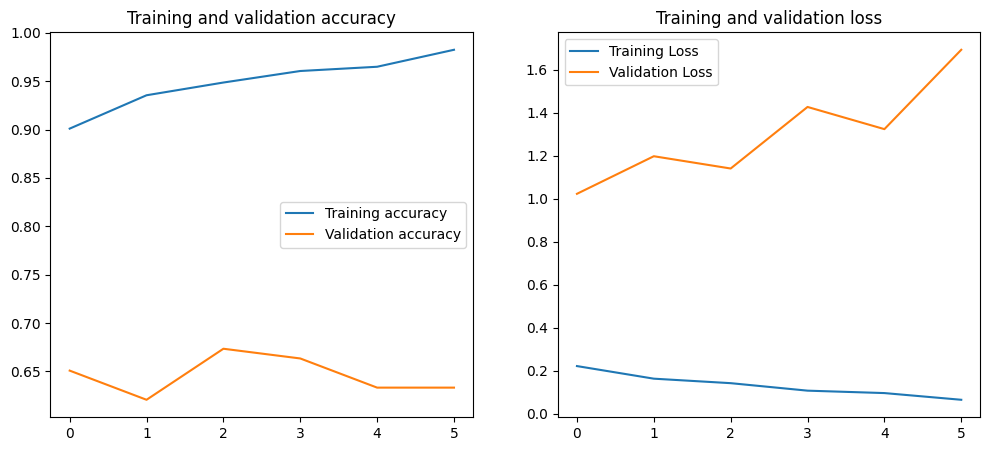

In [27]:
# Skapar datageneratorn för träningsdatan
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)

early_stopper = EarlyStopping(
    monitor='val_loss',
    patience=4,
    verbose=1,
    restore_best_weights=True
)

# Tränar modellen med EarlyStopping och data augmentation
model_aug.fit(
    train_generator,
    epochs=40,
    validation_data=(X_val, y_val),
    callbacks=[early_stopper]
)

# Testar modellen
test_loss, test_accuracy = model_aug.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")
plot_training_history(history)


Jag har ju ändrat bildstorlekarna så det stämmer överens på alla, tagit bort de största respektive minsta för att minska möjligheten för knasiga bilder. Testat med augmentation och utan för att kunna se vad som fungerar bäst. Även testat öka och sänka convolution och Maxpooling lager för att se hur det påverkar.

# 2b

# Andra test med andra parametrar utan augmentering

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.5875 - loss: 1.8167 - val_accuracy: 0.4975 - val_loss: 12.4669
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.7269 - loss: 0.5511 - val_accuracy: 0.4975 - val_loss: 9.3739
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.8260 - loss: 0.3761 - val_accuracy: 0.4975 - val_loss: 5.3529
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.8960 - loss: 0.2618 - val_accuracy: 0.4975 - val_loss: 3.4775
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.9152 - loss: 0.2168 - val_accuracy: 0.4975 - val_loss: 3.2702
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.9558 - loss: 0.1435 - val_accuracy: 0.5678 - val_loss: 1.0117
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.9670 - loss: 0.1040 - val_accuracy: 0.5352 - val_loss: 2.1489
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 967s 20s/step - accuracy: 0.9723 - loss: 0.0804 - val_accuracy: 0.5754 - val_l

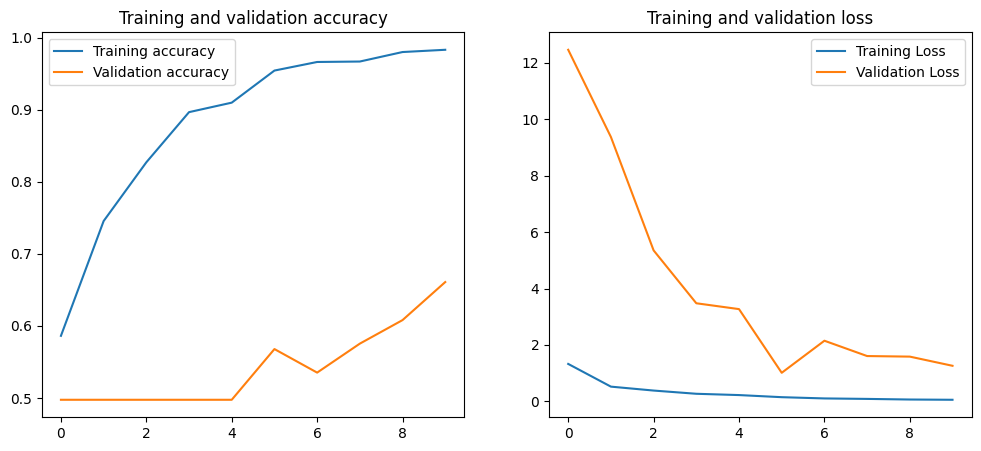

In [28]:

def build_model():
    model = Sequential([
        Input(shape=(250, 200, 3)),
        Conv2D(32, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Flatten(),
        Dropout(0.7),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model
model = build_model()
model_plot = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

# Jämför modellen mot testdatan
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")

def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

plot_training_history(model_plot)

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.9851 - loss: 0.0569 - val_accuracy: 0.6633 - val_loss: 1.1079
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.9826 - loss: 0.0531 - val_accuracy: 0.6533 - val_loss: 1.2315
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.9872 - loss: 0.0445 - val_accuracy: 0.6558 - val_loss: 1.1493
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.9874 - loss: 0.0416 - val_accuracy: 0.6683 - val_loss: 0.9669
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.9741 - loss: 0.0617 - val_accuracy: 0.6633 - val_loss: 1.0561
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.9797 - loss: 0.0579 - val_accuracy: 0.5754 - val_loss: 1.7307
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.9743 - loss: 0.0801 - val_accuracy: 0.6106 - val_loss: 1.3072
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.9726 - loss: 0.0741 - val_accuracy: 0.6834 - val_loss:

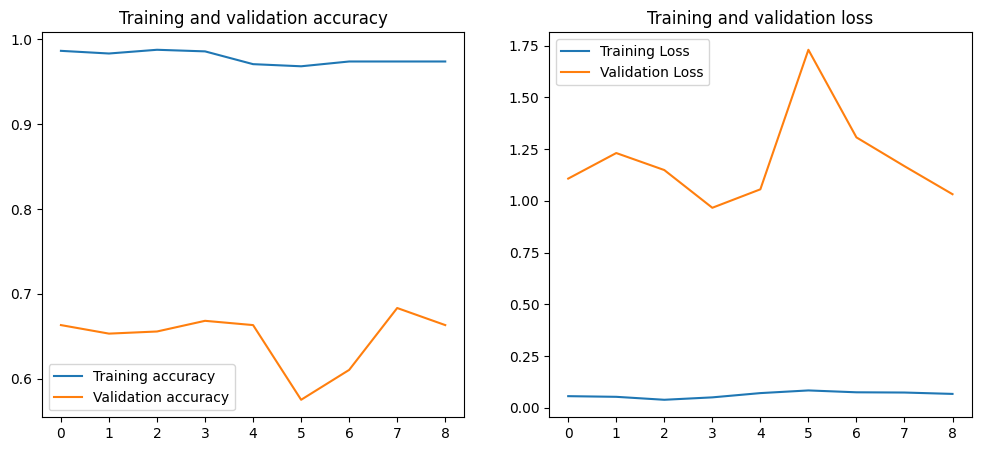

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 208ms/step - accuracy: 0.7241 - loss: 0.7765
Test Accuracy: 0.7214428782463074


In [29]:
early_stopper = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopper]
)

plot_training_history(history)

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")

Här testade jag att lägga till Batch Normalization för att se om det kunde normalisera inputen till varje lager så att nätverket kan träna snabbare och mer stabilt.

Jag justerade antalet filter och lagrens storlek för att fånga fler detaljer från bilderna. Ändrade också storleken på de dolda lagren för att testa om det förbättrade modellens kapacitet att lära sig mer komplexa funktioner.

Fick ett lite bättre resultat än vid första testet.

# 2c) Utvärdera Modellen på Testdata

Det var detta vi pratade om att jag redan hade med test ovan och det var okej.

# 2d) Sammanfattning av Forskningsartiklar och Transfer Learning

Forskning om Djupa Nätverk:

- VGG16: Forskare vid Oxford (Visual Geometry Group) utvecklade detta nätverk. Det är känt för sin djuphet och enkelhet, använder enbart 3x3 konvolutionella filter stegvis följt av max pooling, vilket gör det bra för grundläggande bildigenkänning men det är ganska tungt i antalet parametrar.

- ResNet (Residual Networks): Är känd för sin förmåga att köra mycket djupa nätverk tack vare residuala block, med skip connections som tillåter tränande av mycket djupare nätverk (upp till 152 lager) genom att lösa problemet med vanishing gradients. Detta kan vara effektivt för mycket komplexa bildproblem.

- Xception använder separerbara konvolutioner som kan vara mer effektivt i termer av modellens prestanda på stora datamängder.

- Inception (InceptionV3) är bra på att hantera olika skalförändringar inom bilder tack vare sina konvolutionsblock som kör parallellt.

- Transfer Learning: Denna teknik innebär att man tar en förtränad modell (som VGG16, ResNet, etc.) tränad på en stor databas, och sedan finjustera den för en mer specifik uppgift. Detta är effektivt eftersom de tidiga lagren av en CNN fångar universella funktioner som kanter och texturer som är användbara över olika bildigenkänningsuppgifter. 
    

In [ ]:
# Laddar ett förtränat nätverk (Xception) men utan toppskikten
base_model = Xception(weights='imagenet', include_top=False, input_shape=(200, 250, 3))

# Fryser vikterna i basmodellen förutom de sista tre 
for layer in base_model.layers[:-3]:
    layer.trainable = False

# Gör de sista tre lagren tränbara för att finjustera modellen på min specifika data
for layer in base_model.layers[-3:]:
    layer.trainable = True

# Skapar den nya modellen med anpassade toppskikt
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Bygger modellen manuellt för att definiera output shapes för att kunna se en mer detaljerad och korrekt sammanfattning av modellen. Då inklusive tränbara parametrar och output shapes för varje lager
model.build(input_shape=(None, 200, 250, 3))
model.summary()

history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val))

plot_training_history(history)

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")